#### Companion notebook for topology features 2D CNN with full dataset

In this notebook the following procedures are done:
- Using noisy Takens embeddings matrix
- Training a 2D CNN and testing (here I mean validation, sorry for using them in opposite)
- Plotting evaluation metrics (not doing it with this)
- Visualizing feature maps from the convolutional layers
  

**FYI**: <br>
To use:
- random subsampling
- k-fold cross validation
- weight resetting to avoid parameter leakage
- Monte Carlo dropout
- terminal/shell training with arguments

Check the training .py files that starts with *train*

In [3]:
import os
os.chdir("C:/Users/jako/data/custom_cough/")

import librosa

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt

from IPython.display import Audio

import torch.nn as nn
import torch
from torchaudio.transforms import MelSpectrogram
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA

from utils.helper_functions import *

from gtda.time_series import SingleTakensEmbedding
from gtda.plotting import plot_point_cloud

Manim Community v0.17.3

In [4]:

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=2):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        
    def forward(self, x):
        #x = self.conv(x)
        x = self.pool( self.relu( self.conv(x)  ) )
        return x
        
        

class CustomDataset(Dataset):
    
    def __init__(self, mel_path, annotations_file):
        self.mel_path = mel_path
        self.annotations = pd.read_csv(annotations_file)
        
    
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        mel_sample_path = self._get_mel_path(idx)
        label = self._get_mel_sample_label(idx)
        
        mel = torch.tensor(torch.load(mel_sample_path)).unsqueeze_(0)
        
        return mel, label
        
    
    def _get_mel_path(self, idx):
        
        path = os.path.join(self.mel_path, self.annotations.iloc[idx, 2])
        return path
    
    def _get_mel_sample_label(self, idx):
        return self.annotations.iloc[idx, 1]
        
  
class SingleCNN2D(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = ConvBlock(1, 32)
        self.conv2 = ConvBlock(32, 64)
        self.conv3 = ConvBlock(64, 128)
        self.conv4 = ConvBlock(128, 256)
        
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(481280, 1)

    def forward(self, x):
        x = self.flatten( self.conv4( self.conv3( self.conv2( self.conv1( x ) ) ) ) )
        return self.linear(x)

In [5]:
trainload = CustomDataset("topological_signal", "train_full/full_train_labels.csv")
testload = CustomDataset("topological_signal_test", "test_full/full_test_labels.csv")

trainer = DataLoader(trainload, batch_size=16)
tester = DataLoader(testload, batch_size=16)

In [6]:
trainload.__getitem__(0)[0].shape

torch.Size([1, 3731, 100])

In [7]:
cnn = SingleCNN2D().to("cuda")
initialize_weights(cnn)

In [8]:
loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(cnn.parameters(), lr=0.001)

In [10]:
from torchsummary import summary
summary(cnn, input_size=(1, 3731, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 32, 3733, 102]             320
              ReLU-2        [-1, 32, 3733, 102]               0
         MaxPool2d-3         [-1, 32, 1866, 51]               0
         ConvBlock-4         [-1, 32, 1866, 51]               0
            Conv2d-5         [-1, 64, 1868, 53]          18,496
              ReLU-6         [-1, 64, 1868, 53]               0
         MaxPool2d-7          [-1, 64, 934, 26]               0
         ConvBlock-8          [-1, 64, 934, 26]               0
            Conv2d-9         [-1, 128, 936, 28]          73,856
             ReLU-10         [-1, 128, 936, 28]               0
        MaxPool2d-11         [-1, 128, 468, 14]               0
        ConvBlock-12         [-1, 128, 468, 14]               0
           Conv2d-13         [-1, 256, 470, 16]         295,168
             ReLU-14         [-1, 256, 

#### Only using 1 epoch because these transformed samples consists of 2 mb matrices. 

In [11]:
results = train_pipeline(model=cnn,
               train_dataloader=trainer,
               test_dataloader=tester,
               optimizer=optim,
               loss_fn=loss_fn,
               epochs=1,
               device="cuda")

Epoch: 0 | Train loss: 0.4293 | Train acc: 0.8390 | Test loss: 0.3593 | Test acc: 0.8579 | Test precision 0.9753 | Test recall 0.7410 | Test F1: 0.8422


In [16]:
tks = SingleTakensEmbedding(time_delay=1, dimension=100, stride=30, n_jobs=-1, parameters_type="fixed")

sample_y, sr = librosa.load("validation/clearing_throat.wav", sr=16000)
sample_y2, sr = librosa.load("validation/snoring_throat_issue.wav", sr=16000)
sample_y3, sr = librosa.load("validation/joe_rogan_podcast_2038.wav", sr=16000)

y_tks = tks.fit_transform(sample_y)
y_tks2 = tks.fit_transform(sample_y2)
y_tks3 = tks.fit_transform(sample_y3)


y_tks, y_tks2, y_tks3 = torch.tensor(y_tks)[None, None, :, :].to("cuda"), torch.tensor(y_tks2)[None, None, :, :].to("cuda"), torch.tensor(y_tks3)[None, None, :, :].to("cuda")

#### Kind of a good model when comparing to the other more complex. <br>Maybe because the input data has much more information than the 3D point clouds and the Mel Spectrograms.

In [18]:
print("Prediction sample 'clearing_throat': Cough {} probability".format(round(1 / (1+torch.exp(-cnn(y_tks))).cpu().detach().numpy()[0][0], 2)))
print("Prediction sample 'snoring_throat_issue': Cough {} probability".format(round(1 / (1+torch.exp(-cnn(y_tks2))).cpu().detach().numpy()[0][0], 2)))
print("Prediction sample 'joe_rogan_podcast_2038': Cough {} probability".format(round(1 / (1+torch.exp(-cnn(y_tks3))).cpu().detach().numpy()[0][0], 2)))

Prediction sample 'clearing_throat': Cough 0.47 probability
Prediction sample 'snoring_throat_issue': Cough 0.0 probability
Prediction sample 'joe_rogan_podcast_2038': Cough 0.0 probability


In [19]:
for i in range(len(trainload)):
    if trainload._get_mel_path(i).endswith("1-18755-B-4.pt"):
        print(trainload._get_mel_path(i), i)

topological_signal\1-18755-B-4.pt 475
topological_signal\noise_1-18755-B-4.pt 3261


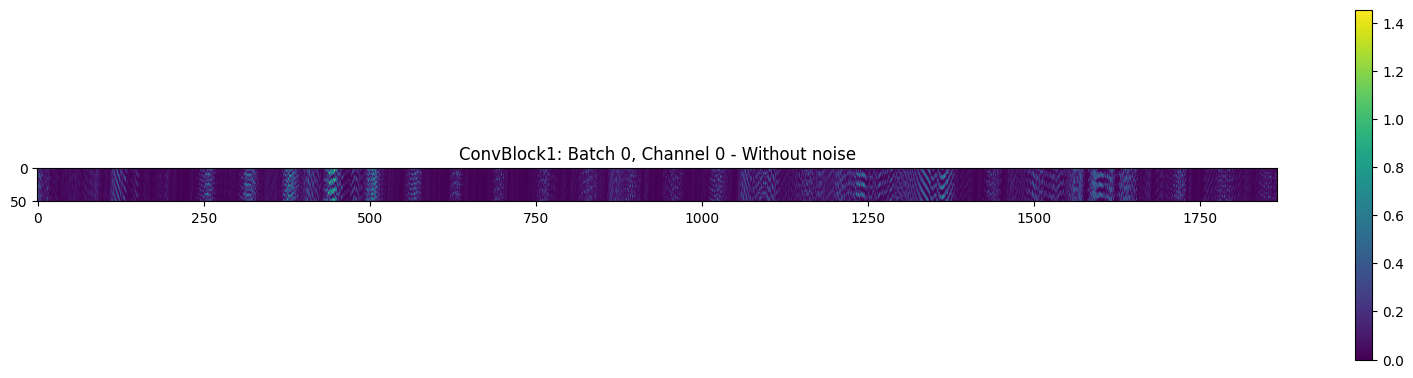

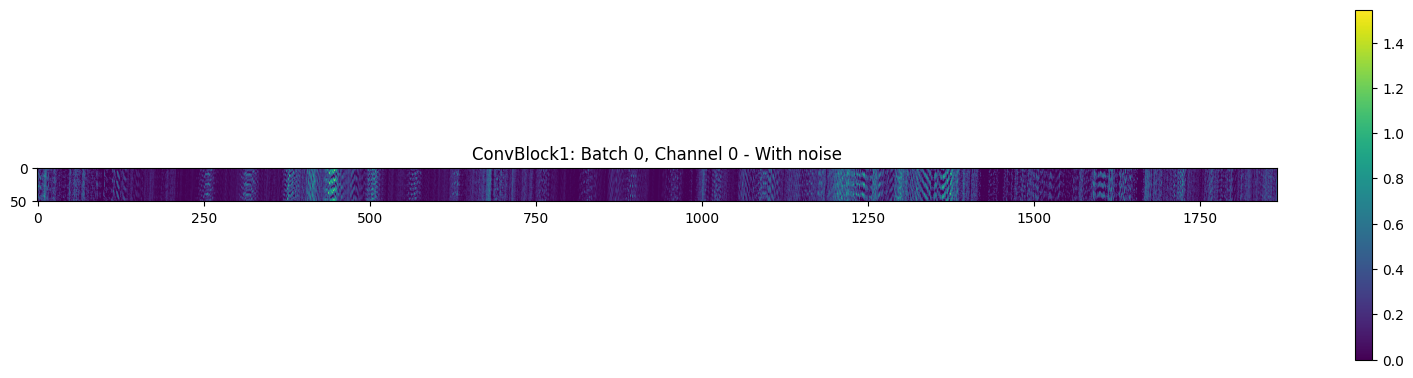

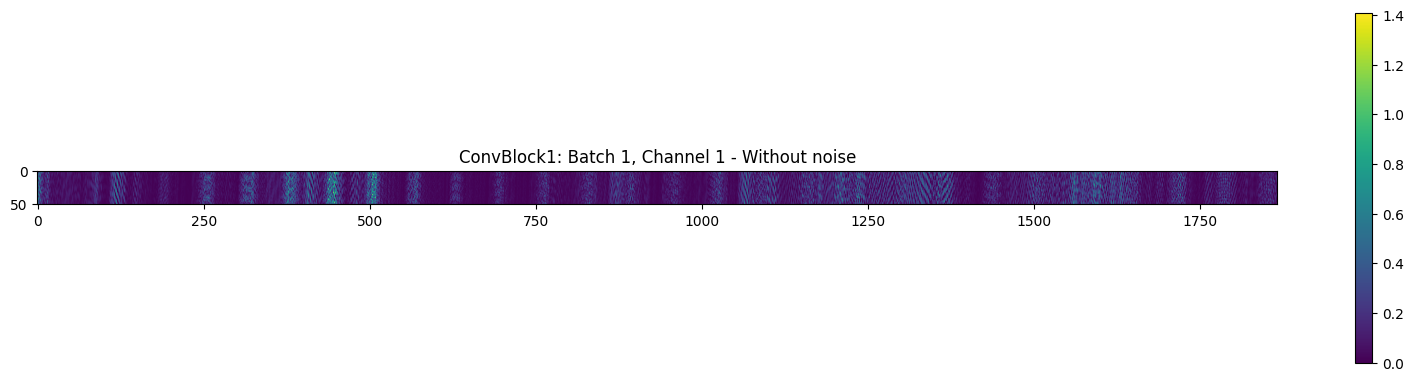

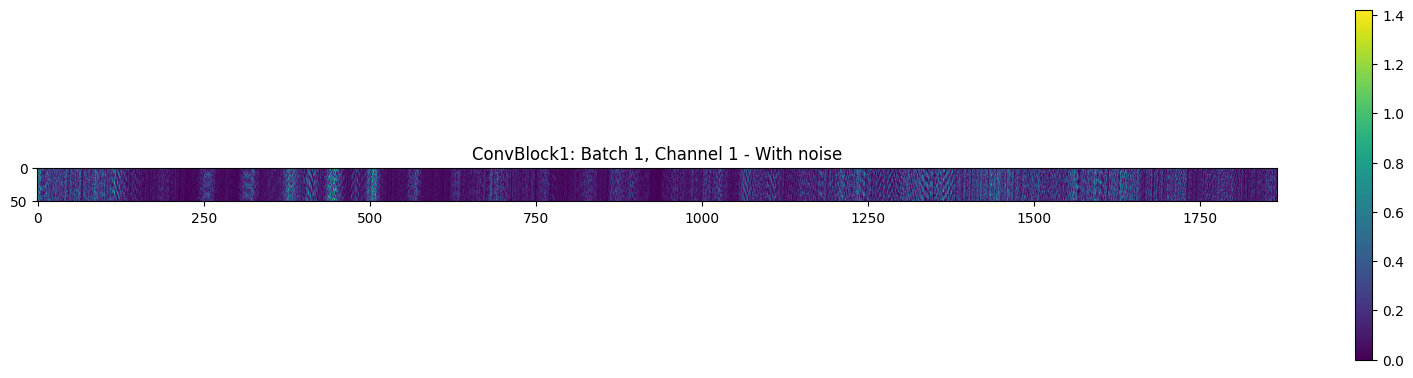

In [24]:
mel_sample = trainload.__getitem__(475)[0]      # Without noise injection
mel_sample_noise = trainload.__getitem__(3261)[0] # With noise injection

output = cnn.conv1(mel_sample.to("cuda"))
output2 = cnn.conv1(mel_sample_noise.to("cuda"))

# Loop over the batch dimension
for i in range(2):
    # Loop over the channels
    for j in range(1):
        fig = plt.figure(figsize=(20,10))
        fig.add_subplot(2, 1, 1)
        plt.imshow(output[i].detach().cpu().numpy().T, cmap='viridis')
        plt.colorbar()
        plt.title(f"ConvBlock1: Batch {i}, Channel {i} - Without noise")

        fig = plt.figure(figsize=(20,10))
        fig.add_subplot(2,1,2)
        plt.imshow(output2[i].detach().cpu().numpy().T, cmap='viridis')
        plt.colorbar()
        plt.title(f"ConvBlock1: Batch {i}, Channel {i} - With noise")
        plt.show()

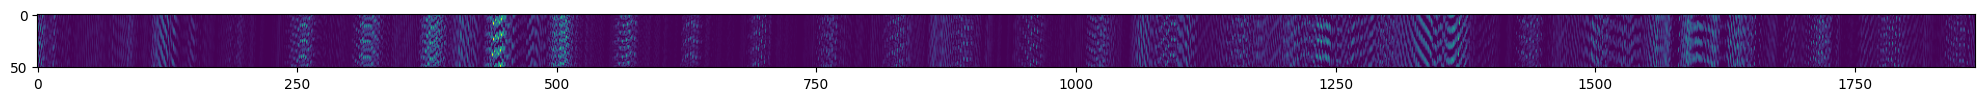

In [26]:
plt.figure(figsize=(25, 50))
plt.imshow(output[0].detach().cpu().numpy().T, cmap='viridis')
